In [1]:
import keras
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
import librosa
from keras.utils import to_categorical

C:\Users\lenovo_pc\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
feature_dim_1 = 100

In [3]:
def get_labels(path):
    labels = os.listdir(path)
    label_indices = np.arange(0, len(labels))    
    return labels, label_indices, to_categorical(label_indices)





In [4]:
from sklearn.model_selection import train_test_split

def get_train_test(split_ratio=0.8, random_state=42):
    # Get available labels
    labels, indices, _ = get_labels(DATA_PATH)

    # Getting first arrays
    X = np.load(labels[0] + '.npy')
    y = np.zeros(X.shape[0])

    # Append all of the dataset into one single array, same goes for y
    for i, label in enumerate(labels[1:]):
        x = np.load(label + '.npy')
        X = np.vstack((X, x))
        y = np.append(y, np.full(x.shape[0], fill_value= (i + 1)))

    assert X.shape[0] == len(y)

    return train_test_split(X, y, test_size= (1 - split_ratio), random_state=random_state, shuffle=True)



def save_data_to_array(path, max_pad_len):
    labels, _, _ = get_labels(path)

    for label in labels:
        # Init mfcc vectors
        mfcc_vectors = []

        wavfiles = [path + '/' + label + '/' + wavfile for wavfile in os.listdir(path + '/' + label)]
        #wavfiles = librosa.util.find_files(db)
        #print(wavfiles)
        x=0
        for wavfile in wavfiles:
            name=label+'_'+str(x)
            mfcc = wav2mfcc(wavfile, name, max_pad_len=max_pad_len)
            mfcc_vectors.append(mfcc)
            x=x+1
        np.save(label + '.npy', mfcc_vectors)
        
        
        

def wav2mfcc(file_path, name, max_pad_len=30):
    wave, sr = librosa.load(file_path)
    mfcc = librosa.feature.melspectrogram(wave, sr=sr, n_mels = feature_dim_1)
    pad_width = max_pad_len - mfcc.shape[1]
    mfcc = np.pad(mfcc, pad_width=((0, 0), (0, pad_width)), mode='constant')
    return mfcc

In [5]:
DATA_PATH = r'C:\Users\lenovo_pc\Desktop\CNN_SR\Dataset-merged'


#db = r'C:\Users\lenovo_pc\Desktop\CNN_SR\SampleData'


# Second dimension of the feature is dim2
feature_dim_2 = 28

# Save data to array file first
save_data_to_array(DATA_PATH,feature_dim_2)

# # Loading train set and test set
X_train, X_test, y_train, y_test = get_train_test()

# # Feature dimension
verbose = 1
num_classes = 2


y_train_hot = to_categorical(y_train)
y_test_hot = to_categorical(y_test)

In [6]:

#X_train = np.array(x_train)
print(X_train.shape)
print(X_test.shape)


(472, 100, 28)
(119, 100, 28)


In [7]:
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.layers import Embedding
from keras.regularizers import l2
from keras import regularizers
from keras.layers import Conv1D, GlobalAveragePooling1D, MaxPooling1D

In [8]:

model = Sequential()
model.add(Conv1D(64, 3, activation='relu', kernel_regularizer=l2(0.02), input_shape=(feature_dim_1,feature_dim_2) ,data_format='channels_first'))
model.add(Conv1D(64, 3, activation='relu', kernel_regularizer=l2(0.05), ))
model.add(MaxPooling1D(3))
#model.add(Conv1D(128, 3, activation='relu', ))
#model.add(Conv1D(128, 3, activation='relu', ))
model.add(GlobalAveragePooling1D())
model.add(Dropout(0.5))
model.add(Dense(2, activation='sigmoid'))


In [9]:
model.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])



In [10]:
#model.fit(x_train, y_train, batch_size=7, epochs=10)

history = model.fit(X_train, y_train_hot, batch_size=150, epochs=50, verbose=verbose, validation_data=(X_test, y_test_hot))

Train on 472 samples, validate on 119 samples
Epoch 1/50
472/472 [==============================] - 10s 22ms/step - loss: 6.7654 - acc: 0.5307 - val_loss: 4.9124 - val_acc: 0.6218
Epoch 2/50
472/472 [==============================] - 9s 19ms/step - loss: 5.9659 - acc: 0.5636 - val_loss: 4.3498 - val_acc: 0.6639
Epoch 3/50
472/472 [==============================] - 9s 19ms/step - loss: 5.5649 - acc: 0.5805 - val_loss: 4.0367 - val_acc: 0.6723
Epoch 4/50
472/472 [==============================] - 9s 20ms/step - loss: 5.0443 - acc: 0.6303 - val_loss: 3.9059 - val_acc: 0.6975
Epoch 5/50
472/472 [==============================] - 9s 19ms/step - loss: 4.9598 - acc: 0.6081 - val_loss: 3.5677 - val_acc: 0.7521
Epoch 6/50
472/472 [==============================] - 10s 20ms/step - loss: 4.5804 - acc: 0.6441 - val_loss: 3.3258 - val_acc: 0.7689
Epoch 7/50
472/472 [==============================] - 9s 18ms/step - loss: 4.2472 - acc: 0.6536 - val_loss: 3.5026 - val_acc: 0.6765
Epoch 8/50
472/472 [=

In [11]:
score = model.evaluate(X_train, y_train_hot, verbose=0) 
print ("model train data score: acc       : ",round(score[1]*100,2) , "%")
print ("model train data score: loss      : ",round(score[0]*100,2) , "%")

score = model.evaluate(X_test, y_test_hot, verbose=0) 
print ("model test data score: acc        : ",round(score[1]*100,2) , "%")
print ("model test data score: loss       : ",round(score[0]*100,2) , "%")


model train data score: acc       :  93.75 %
model train data score: loss      :  38.48 %
model test data score: acc        :  91.6 %
model test data score: loss       :  44.55 %


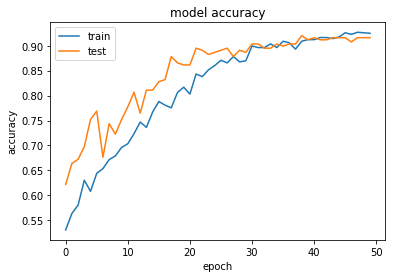

In [12]:
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


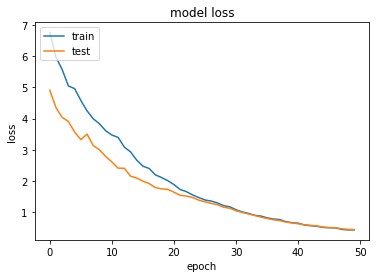

In [13]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [14]:
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, LSTM
from keras.layers import Convolution2D, MaxPooling2D
from keras.optimizers import Adam
from keras.regularizers import l2
from keras.callbacks import EarlyStopping,ReduceLROnPlateau,ModelCheckpoint,TensorBoard,ProgbarLogger
from keras.utils import np_utils
from sklearn import metrics 
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.preprocessing import LabelEncoder
import itertools

In [15]:
print('Build LSTM RNN model ...')
model = Sequential()
model.add(LSTM(units=64, dropout=0.05, recurrent_dropout=0.20, return_sequences=True,input_shape = (feature_dim_1,feature_dim_2)))
model.add(LSTM(units=32, dropout=0.05, recurrent_dropout=0.20, return_sequences=False))
model.add(Dense(2, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='Adamax', metrics=['acc','mse', 'mae', 'mape', 'cosine'])
model.summary()

Build LSTM RNN model ...
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 100, 64)           23808     
_________________________________________________________________
lstm_2 (LSTM)                (None, 32)                12416     
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 66        
Total params: 36,290
Trainable params: 36,290
Non-trainable params: 0
_________________________________________________________________


In [16]:
%%time
# saved model checkpoint file
best_model_file="./best_model_trained.hdf5"
#train_model_file=file_path+"/checkpoints/weights.best_{epoch:02d}-{loss:.2f}.hdf5"
MAX_PATIENT=12
MAX_EPOCHS=50
MAX_BATCH=7

# callbacks
# removed EarlyStopping(patience=MAX_PATIENT)
callback=[ReduceLROnPlateau(patience=MAX_PATIENT, verbose=1),
          ModelCheckpoint(filepath=best_model_file, monitor='loss', verbose=1, save_best_only=True)]

print ("training started..... please wait.")
# training
history=model.fit(X_train, y_train_hot, 
                  batch_size=MAX_BATCH, 
                  epochs=MAX_EPOCHS,
                  verbose=0,
                  validation_data=(X_test, y_test_hot),
                  callbacks=callback) 
model.summary()
print ("training finised!")




training started..... please wait.

Epoch 00001: loss improved from inf to 0.68862, saving model to ./best_model_trained.hdf5

Epoch 00002: loss improved from 0.68862 to 0.65807, saving model to ./best_model_trained.hdf5

Epoch 00003: loss improved from 0.65807 to 0.53929, saving model to ./best_model_trained.hdf5

Epoch 00004: loss improved from 0.53929 to 0.48155, saving model to ./best_model_trained.hdf5

Epoch 00005: loss did not improve from 0.48155

Epoch 00006: loss improved from 0.48155 to 0.47630, saving model to ./best_model_trained.hdf5

Epoch 00007: loss improved from 0.47630 to 0.46314, saving model to ./best_model_trained.hdf5

Epoch 00008: loss improved from 0.46314 to 0.45504, saving model to ./best_model_trained.hdf5

Epoch 00009: loss improved from 0.45504 to 0.43550, saving model to ./best_model_trained.hdf5

Epoch 00010: loss did not improve from 0.43550

Epoch 00011: loss improved from 0.43550 to 0.42680, saving model to ./best_model_trained.hdf5

Epoch 00012: loss

In [17]:
score = model.evaluate(X_train, y_train_hot, verbose=1) 
print ("model train data score       : ",round(score[1]*100,2) , "%")
print ("model train data score: loss : ",round(score[0]*100,2) , "%")
print(score)
score = model.evaluate(X_test, y_test_hot, verbose=1) 
print ("model test data score        : ",round(score[1]*100,2) , "%")
print ("model test data score: loss  : ",round(score[0]*100,2) , "%")

print(score)

472/472 [==============================] - 1s 1ms/step
model train data score       :  97.25 %
model train data score: loss :  10.71 %
[0.10708612961284185, 0.9724576261083958, 0.024669674856556675, 0.06461340252120616, 32306704.33898305, -0.9744249895467596]
119/119 [==============================] - 0s 1ms/step
model test data score        :  96.64 %
model test data score: loss  :  12.29 %
[0.12292424821052231, 0.9663865566253662, 0.030075015672365157, 0.07395528037758435, 36977642.789915964, -0.9683429032814603]


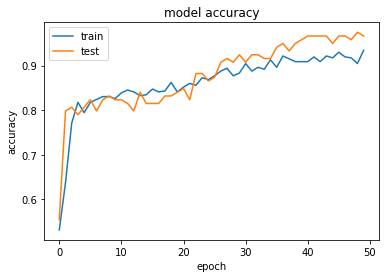

In [18]:
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

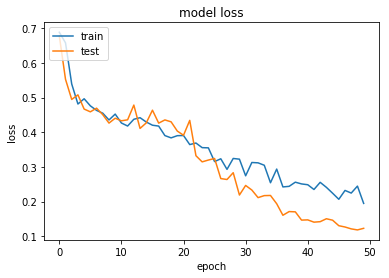

In [19]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()